In [4]:
import os
import cv2
import numpy as np
from keras import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
# This is the data generator. Its job is to generate new images out of existing images by rotating, zooming, shifting and flipping them
datagen = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

In [6]:
# Here we generate the data used to train the model
X_data = []
Y_data = []
images_path = r'C:\Users\HP\Desktop\image classification and XMl on Pokemon dataset\archive\images\images'
images = os.listdir(images_path)

i = 0
images_count = len(images)
for filename in images:
    i += 1
    print(f'{filename}: {i}/{images_count}', end='\r')
    # Load the image from the dataset
    image = cv2.imread(os.path.join(images_path, filename))
    # Resize it to 28x28 to make it faster to train
    resized_image = cv2.resize(image, (28, 28))
    if resized_image is not None:
        # Put the pixels inside X_data and the Pokémon name in Y_data
        X_data.append(resized_image)
        img_name = filename.split('.')[0]
        Y_data.append(img_name)

        # Generate 100 new images for the given Pokémon image by randoming rotating, zooming, shifting and flipping the image
        for _ in range(100):
            random_img = datagen.random_transform(image)
            random_img = cv2.resize(random_img, (28, 28))
            X_data.append(random_img)
            Y_data.append(img_name)

# Divide the pixels by 255 to make their range go from 0 until 1 instead of 0-255. 
# It makes the training faster
X_data = np.array(X_data).astype('float32')
X_data /= 255.0
# Since we need numbers instead of words, we need to convert all the Pokémon names to numbers
encoder = LabelEncoder()
Y_data = encoder.fit_transform(Y_data)
Y_data = to_categorical(Y_data)

# Split the data into training and testing data, making 80% to train and 20% to validate how well we are really predicting the Pokémon names
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

In [ ]:
# Create the AI model 
# It uses a few convolution layers, a few normalization layers and a few dropout layers to avoid overfitting
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(128, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [5]:
# Train the AI using the image data generator. 
# It uses 500 iterations, but we probably won't reach that because each iteraction has a EarlyStopping callback, allowing the training to stop early if we are not making any more progress
model.fit(datagen.flow(X_train, Y_train, batch_size=192),
          epochs=500,
          steps_per_epoch=X_train.shape[0] // 192,
          validation_data=(X_test, Y_test),
          callbacks=[EarlyStopping(monitor='loss', min_delta=1e-10, patience=20, verbose=1),
                     ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, verbose=1),
                     ModelCheckpoint(filepath='weights.h5', monitor='loss',
                                     save_best_only=True, verbose=1)])
# Save the model so we don't have to train again (download the file if you want to test it later)
model.save('model.h5')

Epoch 1/500
340/340 [==============================] - ETA: 0s - loss: 6.0783 - accuracy: 0.0103
Epoch 1: loss improved from inf to 6.07827, saving model to weights.h5
340/340 [==============================] - 47s 95ms/step - loss: 6.0783 - accuracy: 0.0103 - val_loss: 12.5418 - val_accuracy: 0.0013 - lr: 0.0010
Epoch 2/500
340/340 [==============================] - ETA: 0s - loss: 4.7394 - accuracy: 0.0455
Epoch 2: loss improved from 6.07827 to 4.73945, saving model to weights.h5
340/340 [==============================] - 40s 116ms/step - loss: 4.7394 - accuracy: 0.0455 - val_loss: 4.3184 - val_accuracy: 0.0742 - lr: 0.0010
Epoch 3/500
340/340 [==============================] - ETA: 0s - loss: 3.8223 - accuracy: 0.1234
Epoch 3: loss improved from 4.73945 to 3.82231, saving model to weights.h5
340/340 [==============================] - 40s 116ms/step - loss: 3.8223 - accuracy: 0.1234 - val_loss: 7.2419 - val_accuracy: 0.0233 - lr: 0.0010
Epoch 4/500
340/340 [==========================

Epoch 27/500
340/340 [==============================] - ETA: 0s - loss: 0.9720 - accuracy: 0.7362
Epoch 27: loss improved from 1.00114 to 0.97196, saving model to weights.h5
340/340 [==============================] - 22s 64ms/step - loss: 0.9720 - accuracy: 0.7362 - val_loss: 0.5406 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 28/500
340/340 [==============================] - ETA: 0s - loss: 0.9667 - accuracy: 0.7357
Epoch 28: loss improved from 0.97196 to 0.96674, saving model to weights.h5
340/340 [==============================] - 21s 62ms/step - loss: 0.9667 - accuracy: 0.7357 - val_loss: 0.7883 - val_accuracy: 0.7651 - lr: 0.0010
Epoch 29/500
340/340 [==============================] - ETA: 0s - loss: 0.9426 - accuracy: 0.7421
Epoch 29: loss improved from 0.96674 to 0.94259, saving model to weights.h5
340/340 [==============================] - 21s 62ms/step - loss: 0.9426 - accuracy: 0.7421 - val_loss: 0.8039 - val_accuracy: 0.7657 - lr: 0.0010
Epoch 30/500
340/340 [==================

Epoch 80/500
340/340 [==============================] - ETA: 0s - loss: 0.6312 - accuracy: 0.8291
Epoch 80: loss improved from 0.64193 to 0.63120, saving model to weights.h5
340/340 [==============================] - 22s 65ms/step - loss: 0.6312 - accuracy: 0.8291 - val_loss: 0.2564 - val_accuracy: 0.9151 - lr: 0.0010
Epoch 81/500
340/340 [==============================] - ETA: 0s - loss: 0.6250 - accuracy: 0.8293
Epoch 81: loss improved from 0.63120 to 0.62498, saving model to weights.h5
340/340 [==============================] - 22s 65ms/step - loss: 0.6250 - accuracy: 0.8293 - val_loss: 0.1353 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 82/500
340/340 [==============================] - ETA: 0s - loss: 0.6262 - accuracy: 0.8283
Epoch 82: loss did not improve from 0.62498
340/340 [==============================] - 22s 64ms/step - loss: 0.6262 - accuracy: 0.8283 - val_loss: 0.2284 - val_accuracy: 0.9246 - lr: 0.0010
Epoch 83/500
340/340 [==============================] - ETA: 0s - loss: 

340/340 [==============================] - ETA: 0s - loss: 0.5357 - accuracy: 0.8547
Epoch 134: loss did not improve from 0.52180
340/340 [==============================] - 21s 62ms/step - loss: 0.5357 - accuracy: 0.8547 - val_loss: 0.1562 - val_accuracy: 0.9459 - lr: 0.0010
Epoch 135/500
340/340 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.8564
Epoch 135: loss did not improve from 0.52180
340/340 [==============================] - 21s 62ms/step - loss: 0.5295 - accuracy: 0.8564 - val_loss: 0.0751 - val_accuracy: 0.9761 - lr: 0.0010
Epoch 136/500
340/340 [==============================] - ETA: 0s - loss: 0.5170 - accuracy: 0.8578
Epoch 136: loss improved from 0.52180 to 0.51697, saving model to weights.h5
340/340 [==============================] - 21s 63ms/step - loss: 0.5170 - accuracy: 0.8578 - val_loss: 0.3677 - val_accuracy: 0.9015 - lr: 0.0010
Epoch 137/500
340/340 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.8529
Epoch 137: lo

340/340 [==============================] - 22s 64ms/step - loss: 0.4780 - accuracy: 0.8695 - val_loss: 0.0846 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 189/500
340/340 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.8736
Epoch 189: loss improved from 0.47075 to 0.46344, saving model to weights.h5
340/340 [==============================] - 21s 62ms/step - loss: 0.4634 - accuracy: 0.8736 - val_loss: 0.1600 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 190/500
340/340 [==============================] - ETA: 0s - loss: 0.4781 - accuracy: 0.8682
Epoch 190: loss did not improve from 0.46344
340/340 [==============================] - 21s 62ms/step - loss: 0.4781 - accuracy: 0.8682 - val_loss: 0.0979 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 191/500
340/340 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.8698
Epoch 191: loss did not improve from 0.46344
340/340 [==============================] - 21s 63ms/step - loss: 0.4792 - accuracy: 0.8698 - val_l

340/340 [==============================] - 22s 63ms/step - loss: 0.3863 - accuracy: 0.8965 - val_loss: 0.0806 - val_accuracy: 0.9742 - lr: 2.0000e-04
Epoch 216/500
340/340 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.8948
Epoch 216: loss did not improve from 0.38218
340/340 [==============================] - 21s 62ms/step - loss: 0.3901 - accuracy: 0.8948 - val_loss: 0.0955 - val_accuracy: 0.9701 - lr: 2.0000e-04
Epoch 217/500
340/340 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.8955
Epoch 217: loss did not improve from 0.38218
340/340 [==============================] - 21s 62ms/step - loss: 0.3880 - accuracy: 0.8955 - val_loss: 0.1049 - val_accuracy: 0.9660 - lr: 2.0000e-04
Epoch 218/500
340/340 [==============================] - ETA: 0s - loss: 0.3852 - accuracy: 0.8958
Epoch 218: loss did not improve from 0.38218
340/340 [==============================] - 21s 62ms/step - loss: 0.3852 - accuracy: 0.8958 - val_loss: 0.0841 - val_ac

Epoch 243/500
340/340 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8980
Epoch 243: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 243: loss did not improve from 0.36391
340/340 [==============================] - 24s 71ms/step - loss: 0.3785 - accuracy: 0.8980 - val_loss: 0.0739 - val_accuracy: 0.9774 - lr: 2.0000e-04
Epoch 244/500
340/340 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.9027
Epoch 244: loss did not improve from 0.36391
340/340 [==============================] - 25s 72ms/step - loss: 0.3639 - accuracy: 0.9027 - val_loss: 0.0861 - val_accuracy: 0.9731 - lr: 4.0000e-05
Epoch 245/500
340/340 [==============================] - ETA: 0s - loss: 0.3591 - accuracy: 0.9022
Epoch 245: loss improved from 0.36391 to 0.35906, saving model to weights.h5
340/340 [==============================] - 25s 74ms/step - loss: 0.3591 - accuracy: 0.9022 - val_loss: 0.0851 - val_accuracy: 0.9734 - lr: 4.0000e-05
Epoch 

Epoch 270/500
340/340 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.9047
Epoch 270: loss did not improve from 0.35038
340/340 [==============================] - 39s 115ms/step - loss: 0.3536 - accuracy: 0.9047 - val_loss: 0.0697 - val_accuracy: 0.9782 - lr: 8.0000e-06
Epoch 271/500
340/340 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.9043
Epoch 271: loss did not improve from 0.35038
340/340 [==============================] - 39s 114ms/step - loss: 0.3525 - accuracy: 0.9043 - val_loss: 0.0699 - val_accuracy: 0.9779 - lr: 8.0000e-06
Epoch 272/500
340/340 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.9027
Epoch 272: loss did not improve from 0.35038
340/340 [==============================] - 39s 114ms/step - loss: 0.3613 - accuracy: 0.9027 - val_loss: 0.0704 - val_accuracy: 0.9778 - lr: 8.0000e-06
Epoch 273/500
340/340 [==============================] - ETA: 0s - loss: 0.3606 - accuracy: 0.9031
Epoch 273: loss 

In [1]:
import tensorflow as tf

# Specify the path to the saved model file (.h5 or .tf format)
model_path = r'C:\Users\HP\Desktop\image classification and XMl on Pokemon dataset\model.h5'  # Replace with your model's path

# Load the model
model = tf.keras.models.load_model(model_path)

# You can now use the loaded_model for predictions or further operations


In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        25632     
                                                                 
 batch_normalization_2 (Batc  (None, 12, 12, 32)       1

In [3]:
# Evaluate the testing data (the 20% we separated earlier) and the training data we used to train the model. 
# It will output something close to 0.97 (97% accuracy)
evaluation = model.evaluate(X_test, Y_test)
print(evaluation)
evaluation = model.evaluate(X_train, Y_train)
print(evaluation)

NameError: name 'X_test' is not defined

In [3]:
# List all the layers in your model
for layer in model.layers:
    print(layer.name)

conv2d
batch_normalization
conv2d_1
batch_normalization_1
conv2d_2
batch_normalization_2
dropout
conv2d_3
batch_normalization_3
conv2d_4
batch_normalization_4
conv2d_5
batch_normalization_5
dropout_1
conv2d_6
batch_normalization_6
flatten
dropout_2
dense


In [35]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions

from tensorflow.keras import backend as K
model = load_model('model.h5')

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(28, 28))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

test_image_path = r"C:\Users\HP\Desktop\image classification and XMl on Pokemon dataset\archive\images\images\bulbasaur.png" # Replace with the path to your test image
test_image = load_and_preprocess_image(test_image_path)

In [36]:
layer_name = 'conv2d_1'
last_conv_layer = model.get_layer(layer_name)
last_conv_layer.output

<KerasTensor: shape=(None, 24, 24, 32) dtype=float32 (created by layer 'conv2d_1')>

In [37]:
def grad_cam(model, x, layer_name):
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(layer_name)
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap


In [38]:
def grad_cam(model, x, layer_name):
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        
        model_out, last_conv_layer = iterate(x)
        class_idx = tf.argmax(model_out[0])
        loss = model_out[:, class_idx]
        
    grads = tape.gradient(loss, last_conv_layer)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    
    return heatmap.numpy()

gradcam_heatmap = grad_cam(model, test_image, layer_name)

# SmoothGrad
def smooth_grad(model, x, layer_name, n=50, sigma=1.0):
    heatmaps = []
    for _ in range(n):
        noise = tf.random.normal(shape=x.shape, mean=0.0, stddev=sigma)
        noisy_input = x + noise
        heatmap = grad_cam(model, noisy_input, layer_name)
        heatmaps.append(heatmap)
    return np.mean(heatmaps, axis=0)

smoothgrad_heatmap = smooth_grad(model, test_image, layer_name)

In [39]:
import cv2
layer_name = 'conv2d_1'  # Replace with the name of the layer you want to visualize

gradcam_heatmap = grad_cam(model, test_image, layer_name)
smoothgrad_heatmap = smooth_grad(model, test_image, layer_name)

# Rescale the heatmaps to the input image size
gradcam_heatmap = cv2.resize(gradcam_heatmap, (28, 28))
smoothgrad_heatmap = cv2.resize(smoothgrad_heatmap, (28, 28))

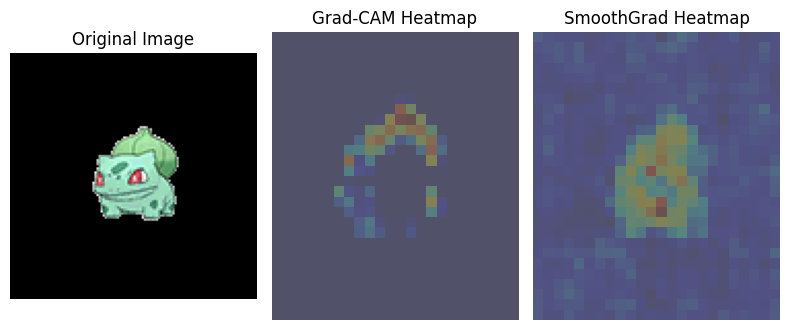

In [40]:
import matplotlib.pyplot as plt

# Load the original test image (without preprocessing)
original_image = image.load_img(test_image_path)

# Visualize the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')


# Visualize Grad-CAM heatmap
plt.subplot(1, 3, 2)
plt.imshow(original_image, alpha=0.6)
plt.imshow(gradcam_heatmap[1], cmap='jet', alpha=0.2)
plt.title('Grad-CAM Heatmap')
plt.axis('off')

# Visualize SmoothGrad heatmap
plt.subplot(1, 3, 3)
plt.imshow(original_image, alpha=0.6)
plt.imshow(smoothgrad_heatmap[0], cmap='jet', alpha=0.2)
plt.title('SmoothGrad Heatmap')
plt.axis('off')

plt.tight_layout()

plt.savefig('6.png')
plt.show()
